<a href="https://colab.research.google.com/github/Larraguibel/DNN_neuroscience/blob/main/blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importaciones

In [ ]:
!pip install --upgrade torch torchvision

### 1.1 Librerías y parámetros

In [ ]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [ ]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

In [ ]:
try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms


if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

--2024-01-20 08:35:23--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.41K  --.-KB/s    in 0s      

2024-01-20 08:35:24 (53.1 MB/s) - ‘utils.py’ saved [4519/4519]



### 1.2 Arcquitectura de AllConvNet

In [ ]:
class AllConvNet(nn.Module):
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 96, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(192)
        self.conv5 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(192)
        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2)
        self.bn6 = nn.BatchNorm2d(192)
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(192)
        self.conv8 = nn.Conv2d(192, 192, 1)
        self.bn8 = nn.BatchNorm2d(192)

        self.class_conv = nn.Conv2d(192, n_classes, 1)

    def forward(self, x):
        x_drop = F.dropout(x, .2)
        conv1_out = F.relu(self.bn1(self.conv1(x_drop)))
        conv2_out = F.relu(self.bn2(self.conv2(conv1_out)))
        conv3_out = F.relu(self.bn3(self.conv3(conv2_out)))
        conv3_out_drop = F.dropout(conv3_out, .5)
        conv4_out = F.relu(self.bn4(self.conv4(conv3_out_drop)))
        conv5_out = F.relu(self.bn5(self.conv5(conv4_out)))
        conv6_out = F.relu(self.bn6(self.conv6(conv5_out)))
        conv6_out_drop = F.dropout(conv6_out, .5)
        conv7_out = F.relu(self.bn7(self.conv7(conv6_out_drop)))
        conv8_out = F.relu(self.bn8(self.conv8(conv7_out)))

        class_out = F.relu(self.class_conv(conv8_out))
        pool_out = F.adaptive_avg_pool2d(class_out, 1)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out


## 2. Transformacion y carga de datos

In [ ]:
# Damos acceso a google drive para guardar modelos

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
class NormalizeNegativeImages(object):

    def __call__(self, item):
        min_value_pixel = torch.min(item)
        if min_value_pixel < 0:
            item -= min_value_pixel
            item /= torch.max(item)
        return item

In [ ]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()
trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255

# Data normal (32x32)

transform_train = transforms.Compose([
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages()
])

#  transformaciones a 8x8 y de vuelta a 32x32 por bilineal

transform_train8x8 = transforms.Compose([
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages()
])

transform_test8x8 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
])

# Crearemos transformaciones sin randomizar nada para la resta de imágenes.

transform_train_no_random = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages()
])

transform_train8x8_no_random = transforms.Compose([
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages()
])

Files already downloaded and verified


In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# loaders normales

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)


# loaders para entrenamiento blurreada

train_loader_blur = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader_blur = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test8x8),
    batch_size=test_batch_size, shuffle=True, **kwargs)

# Loaders sin random (para definir substracted_loader y para ver la primera imagen)

train_loader_no_random = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train_no_random),
    batch_size=train_batch_size, shuffle=False, **kwargs)

train_loader_blur_no_random = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8_no_random),
    batch_size=train_batch_size, shuffle=False, **kwargs)

test_loader_no_random = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=False, **kwargs)

test_loader_blur_no_random = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test8x8),
    batch_size=test_batch_size, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


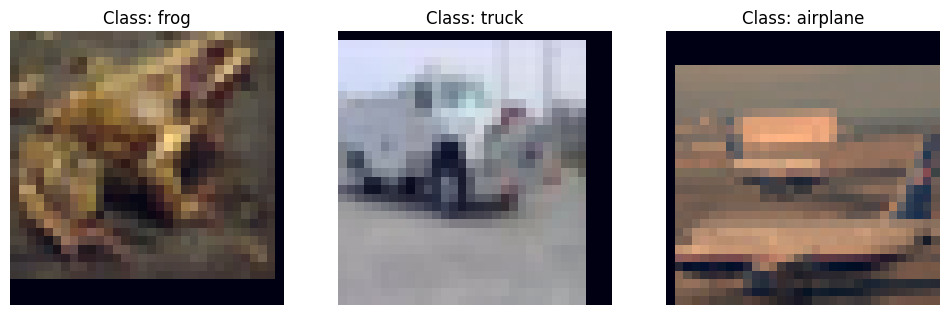

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get one batch from the train_loader
for images, labels in train_loader:
    break  # Break after the first batch

# Choose three random indices
random_indices = np.random.choice(train_batch_size, 3, replace=False)

# Display the three random images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, index in enumerate(random_indices):
    image = images[index].numpy().transpose((1, 2, 0))
    label = labels[index].item()
    class_name = class_names[label]

    axes[i].imshow(image)
    axes[i].set_title(f"Class: {class_name}")
    axes[i].axis('off')

In [ ]:
class SubtractedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.transform = transforms.ToTensor()
        assert len(self.dataset1) == len(self.dataset2), "Datasets must have the same length"

    def __getitem__(self, index):
        item1 = self.dataset1[index]
        item2 = self.dataset2[index]
        subtracted_image = item1[0] - item2[0]
        min_value_pixel = torch.min(item1[0] - item2[0])
        if min_value_pixel < 0:
          subtracted_image -= min_value_pixel
          subtracted_image /= torch.max(subtracted_image)
        return subtracted_image, item1[1]

    def __len__(self):
        return len(self.dataset1)

In [ ]:
subtracted_dataset = SubtractedDataset(train_loader_no_random.dataset, train_loader_blur_no_random.dataset)
subtracted_loader = torch.utils.data.DataLoader(subtracted_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)

subtracted_testset = SubtractedDataset(test_loader_no_random.dataset, test_loader_blur_no_random.dataset)
substracted_testloader = torch.utils.data.DataLoader(subtracted_testset, batch_size=train_batch_size, shuffle=True, **kwargs)

## 3. Entrenamiento

In [ ]:
def initialize_model():

    '''
    Initialize a simple AllConvNet(3) and returns the model and all the
    needed information to train it.
    '''

    global cuda
    model = AllConvNet(3)
    if cuda:
        model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[200, 250, 300], gamma=0.1)

    return_dict = {'model': model, 'optimizer': optimizer,
                  'criterion': criterion, 'scheduler': scheduler}

    return return_dict


def save_plot(path: str, training_data: dict, title: str,
              blur_test_data=None, HF_test_data=None):

    '''
    Generates a graph of epochs vs accuracies by using the keys and values stored
    in a dictionary. Then, the plot is save into the given drive path.
    '''

    epocas = list(training_data.keys())
    accuracies = list(training_data.values())


    ax = plt.figure(figsize=(12,6))
    plt.plot(epocas, accuracies, label=f'Trained with Normal Images')
    plt.scatter(epocas, accuracies, color='orange')
    plt.grid()
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')

    last_acc, last_ep = accuracies[-1], epocas[-1]
    text_upper_left = f'Last epoch: {last_ep}\nLast acc: {last_acc:.2f}'
    plt.text(0.61, 0.04, text_upper_left, transform=plt.gca().transAxes,
            bbox=dict(facecolor='lightgray', edgecolor='lightgray',
                      boxstyle='round,pad=0.5', alpha=0.5))

    for ep, acc in zip(epocas, accuracies):
        if int(ep) % 40 == 0:
            text = f'Epoch: {ep}\nAcc: {acc:.2f}'
            plt.annotate(text, (ep, acc), textcoords="offset points", xytext=(0,-8),
                         ha='center', va='bottom', bbox=dict(facecolor='lightgray',
                         edgecolor='lightgray', boxstyle='round,pad=0.5', alpha=0.5))

    if blur_test_data is not None:
        blur_epochs = list(blur_test_data.keys())
        blur_accs = list(blur_test_data.values())
        plt.plot(blur_epochs, blur_accs, label=f'Testing with Blurred Images')

    if HF_test_data is not None:
        blur_epochs = list(HF_test_data.keys())
        blur_accs = list(HF_test_data.values())
        plt.plot(blur_epochs, blur_accs, label=f'Testing with High Frecuency Images')

    plt.legend()
    plt.tight_layout()
    plt.savefig(path)

In [ ]:
model, optimizer, criterion, scheduler = initialize_model()

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def test(epoch, best_loss, best_epoch, testloader, test_multiples_of=1):

    if epoch % test_multiples_of == 0:
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in testloader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)

            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target).item()
            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
            acc = 100 * correct/len(test_loader.dataset)

        test_loss /= len(test_loader.dataset)
        print(
            '\nTest set: Average loss: {:.4f}, Accuracy: {} ({:.0f}%)\n'.format(
                test_loss, acc, 100. * correct /
                len(test_loader.dataset)))

        if test_loss < best_loss:
            best_epoch = epoch
            best_loss = test_loss
        return best_loss, best_epoch, acc

    else:
        return 0, 0, 0


Se entrena la red y se guardan los datos cada cierto numero de iteraciones

In [ ]:
def checkpoints(current_epoch: int, train_acc: int, blur_acc: int, HF_acc: int,
                train_dict: dict, blur_test_dict: dict, HF_test_dict: dict,
                last_epoch: int, save_every=10):

    if (current_epoch) % save_every == 0 or current_epoch == last_epoch:

        try:
          train_dict[f'{current_epoch}'] = train_acc.item()
          blur_test_dict[f'{current_epoch}'] = blur_acc.item()
          HF_test_dict[f'{current_epoch}'] = HF_acc.item()

        except AttributeError:
          train_dict[f'{current_epoch}'] = acc
          blur_test_dict[f'{current_epoch}'] = blur_acc
          HF_test_dict[f'{current_epoch}'] = HF_acc

        finally:
          checkpoint = {
              'pretrained_epochs': current_epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'final_accuracy': acc,
              'training_data_dict': train_dict,
              'blur_test_dict': blur_test_dict,
              'HF_test_dict': HF_test_dict
              }

          std_text = '/content/gdrive/MyDrive/Christ Diego Mircea Sebastian/resultados experimentos'
          checkpoint_path = std_text + f'/allconv_noblur_checkpts/checkpoint_epoch_{current_epoch}.pt'
          torch.save(checkpoint, checkpoint_path)
          print(f'\nCheckpoint saved at epoch {current_epoch}.\n ')

    return train_dict

## 4. Entrenar

In [ ]:
# Ojito con ejecutarlo mal y perder avances
best_blur_loss, best_blur_epoch = float("inf"), -1
best_HF_loss, best_HF_epoch = float("inf"), -1
training_data_dict = {}
blur_test_dict = {}
HF_test_dict = {}

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
model_stuff = initialize_model()
model = model_stuff['model']
optimizer = model_stuff['optimizer']
criterion = model_stuff['criterion']
scheduler = model_stuff['scheduler']

for epoch in range(0, 331):
    train(epoch)
    scheduler.step()
    best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch, test_loader)

    best_blur_loss, best_blur_epoch, blur_acc = test(epoch, best_blur_loss, best_blur_epoch, test_loader_blur, test_multiples_of=10)

    best_HF_loss, best_HF_epoch, HF_acc = test(epoch, best_HF_loss, best_blur_epoch, substracted_testloader, test_multiples_of=10)

    checkpoints(current_epoch=epoch, train_acc=acc, blur_acc=blur_acc, HF_acc=HF_acc,
                train_dict=training_data_dict, blur_test_dict=blur_test_dict,
                HF_test_dict=HF_test_dict, last_epoch=330)

## 5. Plotting y guardar

In [ ]:
model, optimizer, criterion, scheduler = initialize_model()
std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea Sebastian/resultados experimentos/'
path = std_text + f'/allconv_noblur_checkpts/checkpoint_epoch_330.pt'
model_data = torch.load(path)
model_state_dict = model_data['model_state_dict']

In [ ]:
model_data.keys()

dict_keys(['pretrained_epochs', 'model_state_dict', 'optimizer_state_dict', 'final_accuracy', 'training_data_dict', 'blur_test_dict', 'HF_test_dict'])

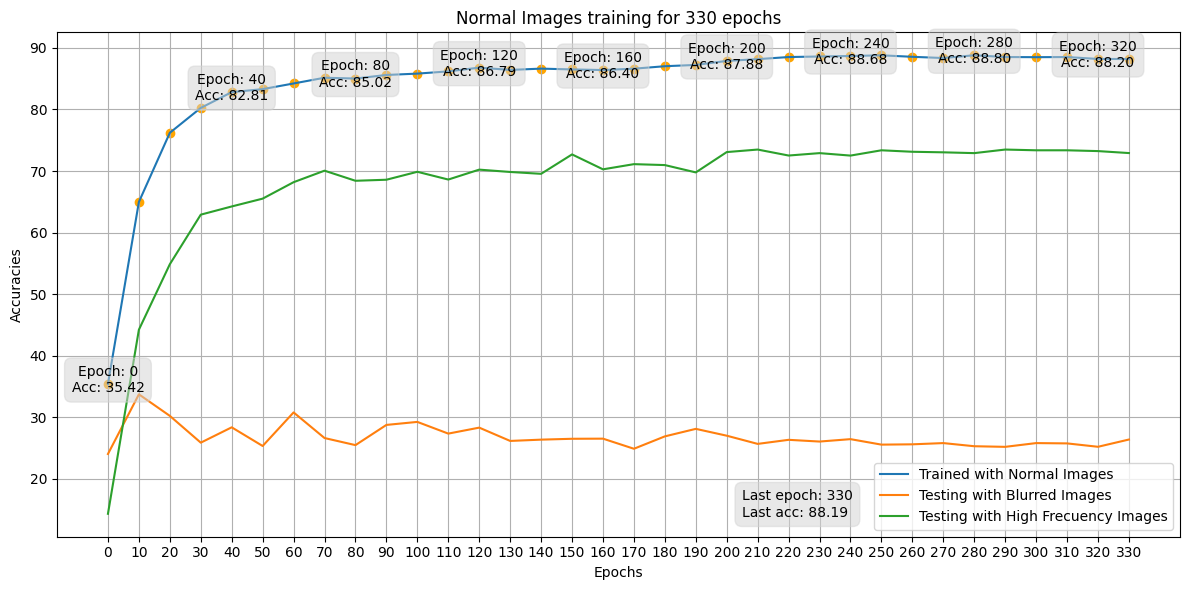

In [ ]:
training_data_dict = model_data['training_data_dict']
path = f'/content/gdrive/MyDrive/Christ Diego Mircea Sebastian/resultados experimentos/Graficos/HF training graphs/No_HF_training'
save_plot(path=path, training_data=training_data_dict, title='Normal Images training for 330 epochs',
          blur_test_data=model_data['blur_test_dict'],
          HF_test_data=model_data['HF_test_dict'])